# **Global Sentiment**

Este es el notebook que usaremos para el scrapeo de datos


In [104]:
import datetime
from datetime import timedelta

import os
import re

import snscrape.modules.twitter as snstwitter

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

## **Parameter Settings**

In [105]:
date_init = "2017-01-02"
date_limit = "2021-06-14"

## **Read Databases**

In [106]:
t_path = "JABA/data/tweets"
t_file = "tweet_list.csv"
s_file = "tweet_sentiment_nltk.csv"

La base de datos esta formada por millones de filas y no usaremos todas las columnas, por lo que, para acelerar el proceso, eliminaremos las columnas no usadas.

En este caso, ademas, la columna Text, es la columna con mayor peso en memoria, por lo que eliminarla aligerara la carga en RAM.

In [107]:
unused_columns = ['Text', 'Tweet Id', 'NumReplies', 'NumRetweets', 'IDOriginalRetweeted', 'isVerified'  ]

def drop_unused_columns(dataframe):
    return dataframe.drop(unused_columns,  axis=1)

def prepare_data(dataframe):
    dataframe["Datetime"] = pd.to_datetime(dataframe["Datetime"])
    dataframe['sentiment_v'] = ( 1 + np.log2(1 + dataframe['NumLikes']) ) * dataframe['sentiment'] 
    dataframe["round_datetime"] = dataframe["Datetime"].dt.floor("30T")
    
    dataframe["date"] = dataframe["Datetime"].dt.date
    dataframe = dataframe.set_index('date')
    
    dataframe = dataframe.groupby(['round_datetime', 'Username']).agg({'sentiment_v' : 'sum' , 'Datetime':'count'})
    dataframe['sentiment_v2'] = np.log2(1+dataframe['Datetime']) / dataframe['Datetime'] * dataframe['sentiment_v']
    return dataframe.groupby('round_datetime').sum()
    
def get_data():
    frames = []
    date_from = datetime.datetime.strptime(date_init, '%Y-%m-%d').date()
    date_until = datetime.datetime.strptime(date_limit, '%Y-%m-%d').date()
    
    if date_from >= date_until:
        return pd.DataFrame()
    
    i = 0
    while date_from < date_until:
        i += 1
        
        folder = os.path.join(t_path, str(date_from))
        # TODO Check if file exists
        if i%365 == 0:
            print(f"Step {i} : {folder}")

        tweet_file = os.path.join(folder, t_file)
        sentiment_file = os.path.join(folder, s_file)

        tweet_df = pd.read_csv(tweet_file, sep=";")
        tweet_df = drop_unused_columns(tweet_df)

        sent_df = pd.read_csv(sentiment_file, sep=";")

        tweet_df = prepare_data(tweet_df.join(sent_df))
        
        frames += [tweet_df]
        
        date_from = date_from + timedelta(days=1)

    return pd.concat(frames, ignore_index=False)
    

In [108]:
df = get_data()

Step 365 : JABA/data/tweets\2018-01-01
Step 730 : JABA/data/tweets\2019-01-01
Step 1095 : JABA/data/tweets\2020-01-01
Step 1460 : JABA/data/tweets\2020-12-31


## **Get Bitcoin Data**

In [109]:
b_path = "JABA/data/bitcoin"
b_file = "bitcoin.csv"

b_limit = date_limit

In [110]:
btc_df = pd.DataFrame()

frames = []
date_from = datetime.datetime.strptime(date_init, '%Y-%m-%d').date()
date_until = datetime.datetime.strptime(date_limit, '%Y-%m-%d').date()

i = 0
while date_from < date_until:
    i += 1

    folder = os.path.join(b_path, str(date_from))
    btc_file = os.path.join(folder, b_file)
    # TODO Check if file exists
    if i%365 == 0:
        print(f"Step {i} : {folder}")

    b_df = pd.read_csv(btc_file, sep=";")
    frames += [b_df]

    date_from = date_from + timedelta(days=1)

btc_df = pd.concat(frames, ignore_index=False)

Step 365 : JABA/data/bitcoin\2018-01-01
Step 730 : JABA/data/bitcoin\2019-01-01
Step 1095 : JABA/data/bitcoin\2020-01-01
Step 1460 : JABA/data/bitcoin\2020-12-31


## **Preparar Datos**

In [111]:
btc_df['round_datetime'] = pd.to_datetime(btc_df['round_datetime'])
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])
btc_df = btc_df.set_index('round_datetime')
btc_df['timestamp_round'] = btc_df['timestamp'].dt.floor('30T')

In [112]:
btc_df['Close'] = btc_df['Close'].replace(to_replace=0, method='ffill')
btc_df = btc_df.groupby("timestamp_round").mean()
 

In [113]:
btc_df = btc_df[date_init:date_limit]

In [114]:
btc_df.index = btc_df.index.tz_localize(None)
df.index = df.index.tz_localize(None)

In [115]:
merge = pd.merge(df,btc_df, how='inner', left_index=True, right_index=True)
#merge = pd.merge(merge,df_gb_c, how='inner', left_index=True, right_index=True)

In [116]:
del df, btc_df

## Correlation

<AxesSubplot:>

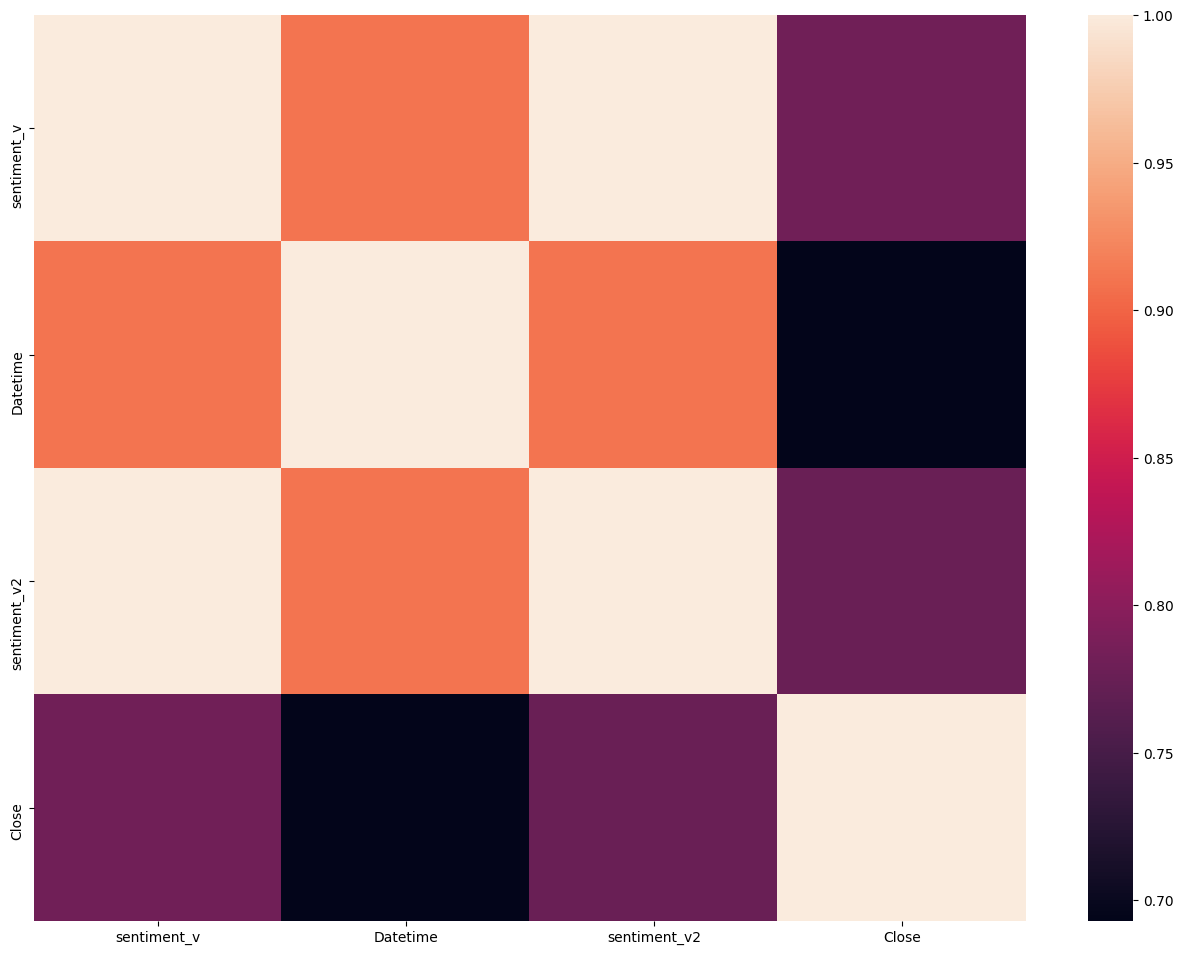

In [117]:
sns.heatmap(merge.corr())

In [118]:
merge['sentiment_v2'].corr(merge['Close'])

0.7767161875404395

## **Plot Results**

In [121]:
merge['Close_z'] = np.log(merge['Close'])
merge['sentiment_vz'] = np.log(merge['sentiment_v'] * 52)
merge['sentiment_v2z'] = np.log(merge['sentiment_v2'] * 52)

C:\Users\whiwho\Anaconda3\envs\JABA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Price (USD)')

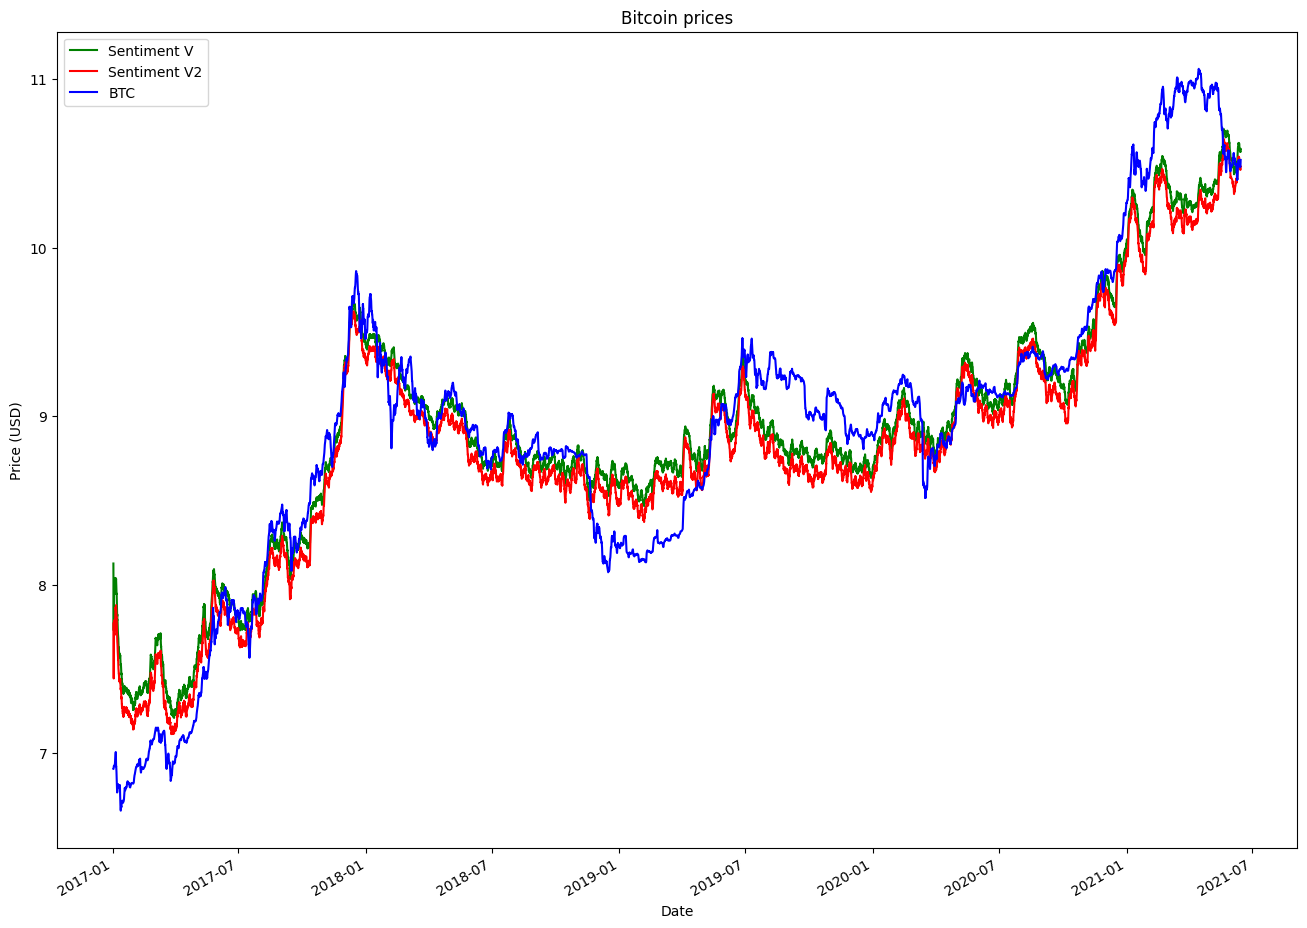

In [122]:
merge['sentiment_vz'].ewm(span = 600).mean().plot(style = 'g', label = 'Sentiment V')
merge['sentiment_v2z'].ewm(span = 500).mean().plot(style = 'r', label = 'Sentiment V2')
merge['Close_z'].ewm(span = 40).mean().plot(style = 'b', label = 'BTC')

plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 100
plt.legend()
plt.title("Bitcoin prices")
plt.xlabel('Date')
plt.ylabel('Price (USD)')

Index of the max corr 12
Max corr 0.8645152152736361


C:\Users\whiwho\Anaconda3\envs\JABA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

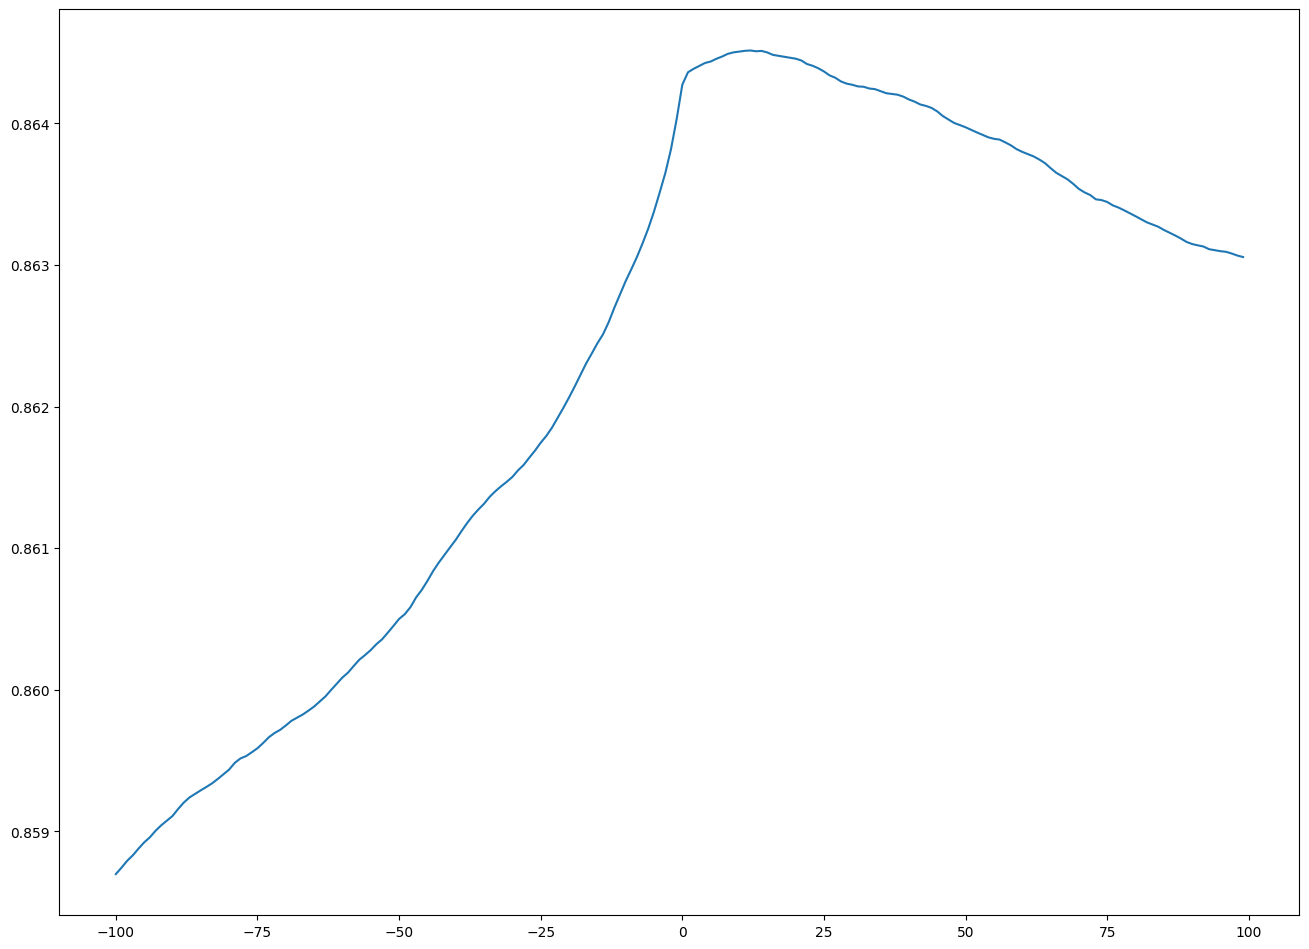

In [127]:
coor_data = []

corr_index_range = 100

for i in range(-corr_index_range,corr_index_range):
    merge2 = merge.shift(periods=i)
    #print(f"Con shift %i el corr es %.4f " % (i, merge2['sentiment_zz'].corr(merge['Close'])))
    coor_data += [merge2['sentiment_v2z'].corr(merge['Close_z'])]


print(f"Index of the max corr {-corr_index_range+coor_data.index(max(coor_data))}")
print(f"Max corr {max(coor_data)}")

sns.lineplot(range(-100,100),coor_data)

## **ARIMA**

In [61]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(merge['Close'],order=(1, 1,1 ))


results=model.fit()


NameError: name 'AutoReg' is not defined

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

model=AutoReg(merge['Close'], lags=12000)


results=model.fit()



In [ ]:
from pandas.tseries.offsets import DateOffset

#future_df['close'] = future_df['close'].fillna(0)
result_data = results.predict(start = 71881, end = 82001, dynamic= False)
pd.concat([merge['Close'], result_data[236:]]).plot(figsize=(12, 8))

In [53]:
len(merge['Close'])

71881

## Linear regression

No vale de nada, pero es para probar un poco.

In [132]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [136]:
reg = LinearRegression().fit(merge[['Close']].to_numpy(), merge['sentiment_v'].to_numpy())

In [138]:
reg.score(merge[['Close']].to_numpy(), merge['sentiment_v'].to_numpy())

0.6096779318714289